In [1]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import json
import requests
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx

from networkx.readwrite import json_graph
from networkx.algorithms import community

In [3]:
df = pd.read_csv('2008.csv')[['Month', 'DayofMonth', 
                              'Year', 'ArrTime', 'DepTime',
                              'Origin', 'Dest', 
                              'Cancelled', 'FlightNum']]

## Preprocessing

In [4]:
df['Date'] = df['Year'].astype(str) +"-"+ df['Month'].astype(str) +"-"+ df['DayofMonth'].astype(str)

In [5]:
df.head()

,Month,DayofMonth,Year,ArrTime,DepTime,Origin,Dest,Cancelled,FlightNum,Date
0,1,3,2008,2211.0,2003.0,IAD,TPA,0,335,2008-1-3
1,1,3,2008,1002.0,754.0,IAD,TPA,0,3231,2008-1-3
2,1,3,2008,804.0,628.0,IND,BWI,0,448,2008-1-3
3,1,3,2008,1054.0,926.0,IND,BWI,0,1746,2008-1-3
4,1,3,2008,1959.0,1829.0,IND,BWI,0,3920,2008-1-3


In [6]:
df = df.loc[df['Cancelled'] != 1]
df = df.drop(['Month', 'DayofMonth', 'Year', 'Cancelled'], axis=1)

In [7]:
df = df.dropna()

In [8]:
# Поля с датой и временем, переведём в формат datetime
def col_to_datetime(df, col):
    df[col] = df[col].astype(int)
    df[col] = df[col].astype(str)
    df[col] = ('0'*3) + df[col]
    df[col] = df[col].str.replace('.*(?=....$)', '', regex=True)
    df[col] = df[col].str.replace('(?<=^..)(?!.$)', ':', regex=True)
    df[col] = df[col].str.replace('^24', '00', regex=True)
    df[col] = df[col] + ":00"
    df[col] = df['Date'] + " " + df[col]
    df[col] = df[col].astype('datetime64[ns]')

In [9]:
col_to_datetime(df, 'ArrTime')
col_to_datetime(df, 'DepTime')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6858079 entries, 0 to 7009727
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ArrTime    datetime64[ns]
 1   DepTime    datetime64[ns]
 2   Origin     object        
 3   Dest       object        
 4   FlightNum  int64         
 5   Date       object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 366.3+ MB


In [11]:
df.head()

,ArrTime,DepTime,Origin,Dest,FlightNum,Date
0,2008-01-03 22:11:00,2008-01-03 20:03:00,IAD,TPA,335,2008-1-3
1,2008-01-03 10:02:00,2008-01-03 07:54:00,IAD,TPA,3231,2008-1-3
2,2008-01-03 08:04:00,2008-01-03 06:28:00,IND,BWI,448,2008-1-3
3,2008-01-03 10:54:00,2008-01-03 09:26:00,IND,BWI,1746,2008-1-3
4,2008-01-03 19:59:00,2008-01-03 18:29:00,IND,BWI,3920,2008-1-3


In [12]:
df['Flight_Index'] = df.index

arriving_flights = df.loc[:, ('ArrTime','Origin', 'Dest', 'Flight_Index')]
departing_flights = df.loc[:, ('DepTime', 'Origin', 'Dest', 'Flight_Index')]

arriving_flights['ActionTime'] = arriving_flights.loc[:, ('ArrTime')]
departing_flights['ActionTime'] = departing_flights.loc[:, ('DepTime')]

In [13]:
# Взлёт и позадка - это разные события, на этой основе и построим симуляцию.
# Это сделано для того, чтобы разделить здоровые рейсы от зараженных, чтобы рейс не заражался "в полёте"
all_flights = pd.concat([arriving_flights, departing_flights], ignore_index=True)

In [14]:
all_flights = all_flights.sort_values(['ActionTime'])
all_flights.loc[all_flights['ArrTime'].isna(), 'FlightType'] = 'Dep'
all_flights.loc[all_flights['DepTime'].isna(), 'FlightType'] = 'Arr'
all_flights = all_flights.drop(['ArrTime', 'DepTime'], axis=1)
all_flights

,Origin,Dest,Flight_Index,ActionTime,FlightType
7272623,LAX,DTW,428607,2008-01-01 00:00:00,Dep
236012,SFO,SAN,243790,2008-01-01 00:00:00,Arr
287289,HOU,HRL,296192,2008-01-01 00:00:00,Arr
387490,MIA,CLT,399744,2008-01-01 00:00:00,Arr
249085,PHX,STL,257285,2008-01-01 00:00:00,Arr
...,...,...,...,...,...
6614819,ATL,PIT,6758018,2008-12-31 23:58:00,Arr
6644826,DEN,BOI,6788915,2008-12-31 23:58:00,Arr
6720544,MSP,SLC,6867744,2008-12-31 23:59:00,Arr
13380289,HNL,SFO,6663085,2008-12-31 23:59:00,Dep


## Симуляция

In [15]:
import random
from tqdm import tqdm


# установим также порог(threshold), после которого симуляция останавливается
def start_infection(airport, prob, df, threshold=90, verbose=True):
    healthy_airports = []
    infected_flights = []
    list_of_airports = []
    dates = []
    percents_of_infected = []
    probs = []
    
    airports = pd.Series(pd.concat([df['Dest'], df['Origin']]).unique())
    spread_infection = pd.DataFrame(airports, columns=['airport'])
    spread_infection['infection'] = 0
    spread_infection.loc[spread_infection['airport'] == airport, 'infection'] = 1
    
    for i in tqdm(df.itertuples(), total=len(df), disable = not verbose):
        
        # сразу пропустить, если рейс из здорового аэропорта
        if i[3] in  healthy_airports:
            healthy_airports.remove(i[3])
            continue
            
        airport_of_origin = i[1]
        airport_of_dest = i[2]
        
        #Заражён ли аэропорт прибытия/отбытия
        infected_or_not_orig = bool(spread_infection.loc[spread_infection['airport'] == airport_of_origin, 'infection'].all())
        infected_or_not_dest = bool(spread_infection.loc[spread_infection['airport'] == airport_of_dest, 'infection'].all())
        
        # Доля зараженых аэропортов
        prop_infected = (spread_infection['infection'].value_counts(normalize=True) * 100)[1]
        
        # Если рейс прибывающий - ...
        if i[5] == 'Arr':
            # пропустить, если аэропорт прибытия уже заражён
            if infected_or_not_dest:
                continue
                
        # Если рейс отлетает - ...
        if i[5] == 'Dep':
            # и самолёт здоровый
            if not infected_or_not_orig:
                # добавить в список "здоровых" данный рейс
                healthy_airports.append(i[3])
                continue
            else:
                # добавить в список зараженный рейс
                infected_flights.append(i[3])
                continue
        
        # Если рейс прибывающий ...
        if i[5] == 'Arr': 
            # и если рейс зараженный - попытаться заразить аэропорт
            if i[3] in infected_flights:
                infected_flights.remove(i[3])
                
                # Запишем процент зараженных; не страшно, 
                # если мы будем делать это не на всех итерациях.
                dates.append(i[4])
                percents_of_infected.append(prop_infected)
                probs.append(prob)
                list_of_airports.append(airport_of_dest)
                
                if random.random() < prob:
                    spread_infection.loc[spread_infection['airport'] == airport_of_dest, 'infection'] = 1
                    spread_infection.loc[spread_infection['airport'] == airport_of_dest, 'infection_date'] = i[4]
        
        # Проведя итерации со стопроцентым шансом заражения, выяснилось, что ВСЕ аэропорты "заражались" только под конец датасета,
        # поэтому остановим симуляцию, когда заразится 90 процентов от всех аэропортов (этот параметр можно менять).
        if np.round(prop_infected, 2) >= threshold: 
            if verbose:
                print(f'{np.round(prop_infected)}% is infected!')
            
            result_dict = {}
            result_dict['dates'] = dates
            result_dict['proportions'] = percents_of_infected
            result_dict['probs'] = probs
            result_dict['airports'] = list_of_airports
            result_df = pd.DataFrame.from_dict(result_dict)
            
            return spread_infection, result_df
        

In [22]:
%%time

probs = [0.01, 0.05, 0.1, 0.5, 1]

all_results = pd.DataFrame()
for prob in enumerate(probs[::-1]):
    result = start_infection('ATL', prob, all_flights)
    all_results = pd.concat([all_results, result[1]])
    all_results.to_csv(f'tables/simulation_results/all_results_{prob}.csv')

  0%|▏                                                                    | 35461/13716158 [00:28<3:01:19, 1257.47it/s]


90.0% is infected!


  1%|▍                                                                    | 77417/13716158 [01:01<2:59:13, 1268.28it/s]


90.0% is infected!


  2%|█▍                                                                  | 295688/13716158 [04:00<3:02:16, 1227.09it/s]


90.0% is infected!


  7%|████▌                                                               | 913037/13716158 [12:31<2:55:39, 1214.82it/s]


90.0% is infected!


 37%|████████████████████████▏                                         | 5021361/13716158 [1:27:44<2:31:56, 953.75it/s]

90.0% is infected!


Wall time: 1h 45min 53s


## Визуализация

### Время для заражения 90% населения, в зависимости от вероятности заражения

<AxesSubplot:xlabel='dates', ylabel='proportions'>

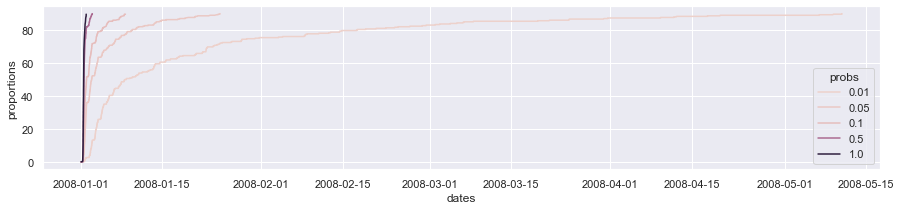

In [24]:
sns.set(rc = {'figure.figsize':(15,3)})
all_results = all_results.reset_index()
all_results = all_results.drop_duplicates()

sns.lineplot(data=all_results,
             x='dates', 
             y='proportions', 
             hue='probs')

In [25]:
neighbors = df.loc[:, ('Origin', 'Dest')]
neighbors['neighbors'] = neighbors['Origin'] +" "+ neighbors['Dest']
neighbors['neighbors'] = neighbors['neighbors'].apply(lambda x: ' '.join(sorted(x.split())))
df.groupby(['Origin', 'Dest']).size()


grouped_neighbors = neighbors.groupby('neighbors').size()
grouped_neighbors = pd.DataFrame({'neighbors':grouped_neighbors.index, 'weight':grouped_neighbors.values})
grouped_neighbors[['a1','a2']]=grouped_neighbors.neighbors.str.split(expand=True)
grouped_neighbors

,neighbors,weight,a1,a2
0,ABE ATL,1679,ABE,ATL
1,ABE BHM,1,ABE,BHM
2,ABE CLE,1583,ABE,CLE
3,ABE CLT,918,ABE,CLT
4,ABE CVG,490,ABE,CVG
...,...,...,...,...
2678,SRQ TPA,2,SRQ,TPA
2679,STL TPA,2161,STL,TPA
2680,STL TUL,1782,STL,TUL
2681,SWF TPA,464,SWF,TPA


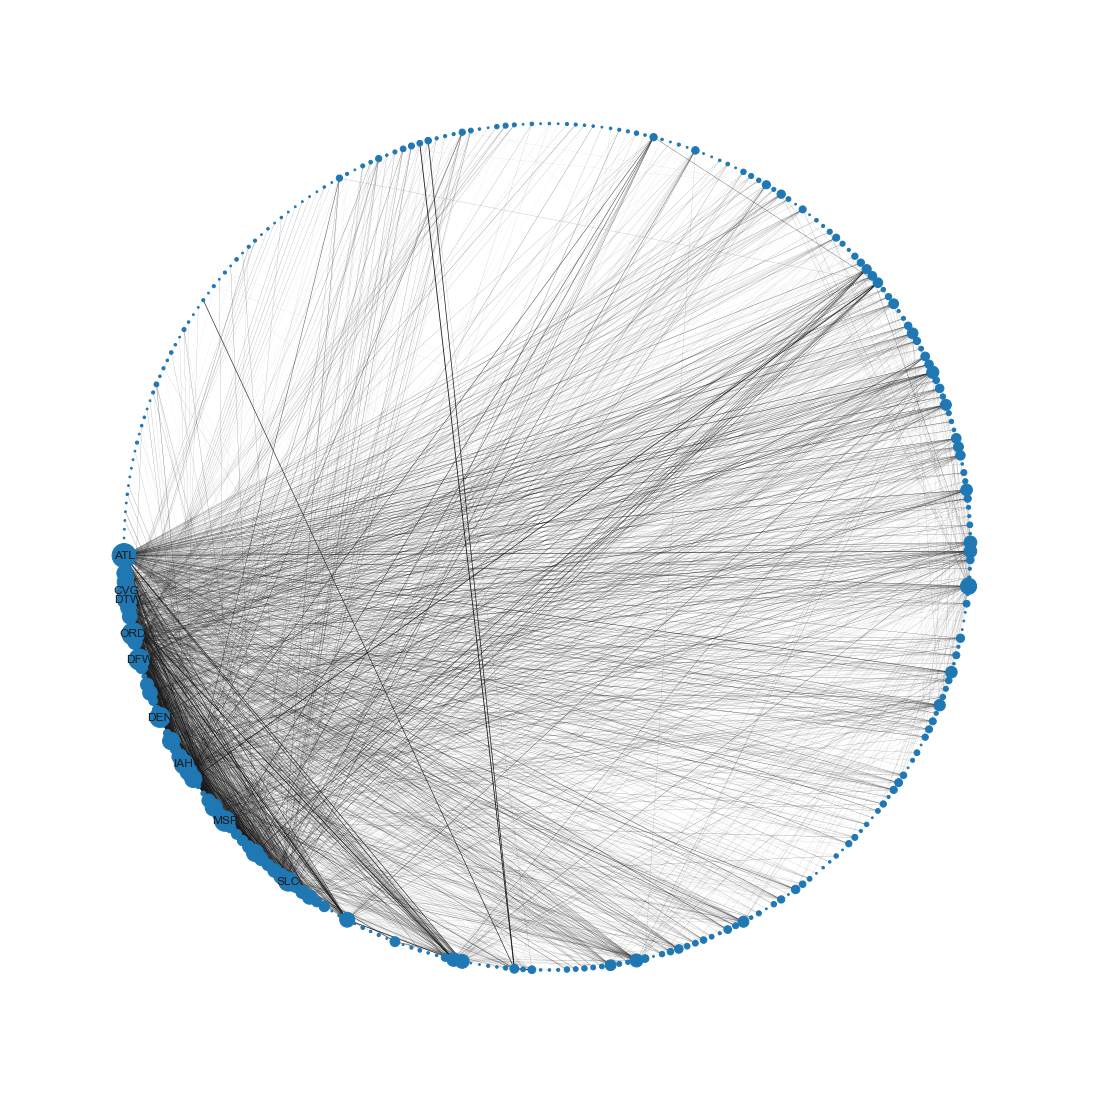

In [26]:
sns.set(rc = {'figure.figsize':(15,15)})
G = nx.from_pandas_edgelist(grouped_neighbors, source='a1', target='a2',
                            edge_attr='weight')

degree_centrality = nx.degree_centrality(G)
degree_centrality_counts = Counter(degree_centrality)

widths = np.array([w for *_, w in G.edges.data('weight')])


th = degree_centrality_counts.most_common(10)[-1][1]
nx.draw_shell(
    G,  
    with_labels=True,
    labels={n[0]: n[0] for n in G.nodes.data() if degree_centrality[n[0]] > th}, 
    node_size=np.array(list(degree_centrality.values())) * 1000,
    width=widths*0.00004,
)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off");

In [30]:
# Топ-10 вершин с наибольшим кол-вом ребер
degree_centrality_counts.most_common(10)

[('ATL', 0.5728476821192053),
 ('ORD', 0.4966887417218543),
 ('DFW', 0.44370860927152317),
 ('MSP', 0.41721854304635764),
 ('DEN', 0.40397350993377484),
 ('DTW', 0.39403973509933776),
 ('IAH', 0.37748344370860926),
 ('CVG', 0.3741721854304636),
 ('SLC', 0.3675496688741722),
 ('EWR', 0.30132450331125826)]

## Оценка метрик

In [31]:
median_time_by_airports = pd.DataFrame()
f = open('median_time_by_airports', 'w')
 
n_iter = 0
for _ in tqdm(range(0, 15)):
    result = start_infection('ATL', 0.5, all_flights, verbose=False)
    df = result[1].loc[:, ('airports', 'dates')]
    df['day_before'] = df['dates'] - np.datetime64("2008-01-01")
    df['day_before'] = df['day_before'].apply(lambda x: x.seconds / 3600)
    median_time_by_airports = pd.concat([median_time_by_airports, df])
    median_time_by_airports.to_csv(f'tables/medians/median_time_by_airports_{n_iter}.csv')
    n_iter += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [16:05<00:00, 64.39s/it]


In [35]:
median_time_by_airports = median_time_by_airports.reset_index()

In [36]:
clustering = pd.DataFrame.from_dict(nx.clustering(G), orient='index', 
                                    columns=['clustering']).reset_index().rename(columns={'index':'airports'})

degree = pd.DataFrame.from_dict(nx.degree(G)).rename(columns={0:'airports', 1:'degree'})

betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(G), 
                                                orient='index', 
                                                columns=['betweenness_centrality']).reset_index().rename(columns={'index':'airports'})

In [37]:
metrics = median_time_by_airports.merge(clustering, on='airports')
metrics = metrics.merge(degree, on='airports')
metrics = metrics.merge(betweenness_centrality, on='airports').drop(['level_0','index'], axis=1)

metrics

,airports,dates,day_before,clustering,degree,betweenness_centrality
0,CHS,2008-01-01 00:57:00,0.950000,0.888889,18,0.000086
1,CHS,2008-01-01 00:57:00,0.950000,0.888889,18,0.000086
2,CHS,2008-01-01 09:13:00,9.216667,0.888889,18,0.000086
3,CHS,2008-01-01 00:57:00,0.950000,0.888889,18,0.000086
4,CHS,2008-01-01 09:13:00,9.216667,0.888889,18,0.000086
...,...,...,...,...,...,...
8246,ERI,2008-01-02 18:32:00,18.533333,1.000000,2,0.000000
8247,ERI,2008-01-02 18:32:00,18.533333,1.000000,2,0.000000
8248,ERI,2008-01-02 18:32:00,18.533333,1.000000,2,0.000000
8249,ERI,2008-01-02 18:32:00,18.533333,1.000000,2,0.000000


<AxesSubplot:xlabel='day_before', ylabel='betweenness_centrality'>

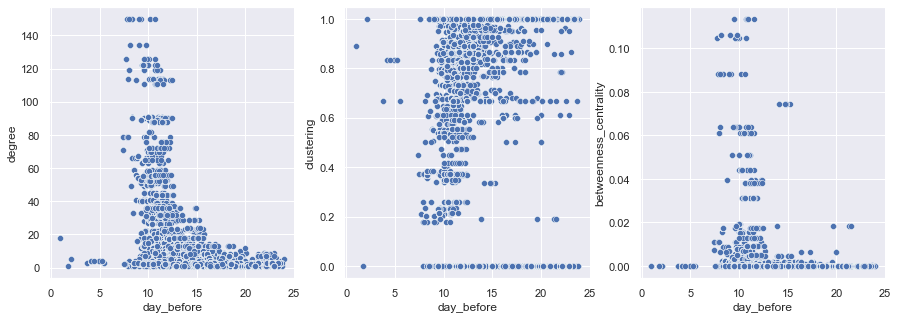

In [38]:
sns.set(rc = {'figure.figsize':(15,5)})
fig, axes = plt.subplots(1, 3)
sns.scatterplot(data=metrics, x="day_before", y="degree", ax=axes[0])
sns.scatterplot(data=metrics, x="day_before", y="clustering", ax=axes[1])
sns.scatterplot(data=metrics, x="day_before", y="betweenness_centrality", ax=axes[2])

<AxesSubplot:>

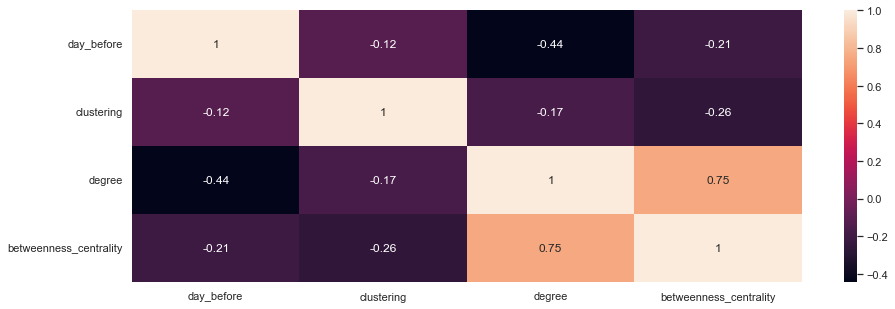

In [39]:
sns.heatmap(metrics.corr(), annot=True)

## Вывод:

Совершенно логично, что количество дней будет обратно коррелировать с degree (количеством ребер), чем их больше, тем меньше дней от начала заражения до заражения других аэропортов.